<a href="https://colab.research.google.com/github/tylaar/notebook/blob/main/DoubleDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
class QNet(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(QNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    return self.fc2(x)

In [3]:
class VANet(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(VANet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
    self.fc_V = torch.nn.Linear(hidden_dim, 1)

  def forward(self, x):
    A = self.fc_A(F.relu(self.fc1(x)))
    V = self.fc_V(F.relu(self.fc1(x)))
    Q = V + A - A.mean(1).view(-1, 1)
    return Q

In [4]:
class DQNExtended:
  def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, dqn_type, device):
    self.action_dim = action_dim
    if dqn_type == 'DuelingDQN':
      self.q_net = VANet(state_dim, hidden_dim, self.action_dim).to(device)
      self.target_q_net = VANet(state_dim, hidden_dim, self.action_dim).to(device)
    else:
      self.q_net = QNet(state_dim, hidden_dim, self.action_dim).to(device)
      self.target_q_net = QNet(state_dim, hidden_dim, self.action_dim).to(device)
    self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
    self.gamma = gamma
    self.epsilon = epsilon
    self.target_update = target_update
    self.count = 0
    self.device = device
    self.dqn_type = dqn_type

  def take_action(self, state):
    if np.random.random() < self.epsilon:
      action = np.random.randint(self.action_dim)
    else:
      state = torch.tensor([state], dtype=torch.float).to(self.device)
      action = self.q_net(state).argmax().item()
    return action

  def max_q_value(self, state):
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    return self.q_net(state).max().item()

  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

    q_values = self.q_net(states).gather(1, actions)
    if self.dqn_type == 'DoubleDQN':
      max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
      max_net_q_values = self.target_q_net(next_states).gather(1, max_action)
    else:
      max_net_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
    q_targets = rewards + self.gamma * max_net_q_values * (1 - dones)
    dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))

    self.optimizer.zero_grad()
    dqn_loss.backward()
    self.optimizer.step()

    if self.count % self.target_update == 0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())

    self.count += 1

In [5]:
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = 11

def dis_to_con(discrete_action, env, action_dim):
  action_lowbound = env.action_space.low[0]
  action_upbound = env.action_space.high[0]
  return action_lowbound + (discrete_action / (action_dim - 1)) * (action_upbound - action_lowbound)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
class ReplayBuffer:
  def __init__(self, capacity):
    self.buffer = collections.deque(maxlen=capacity)

  def add(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))

  def sample(self, batch_size):
    transitions = random.sample(self.buffer, batch_size)
    state, action, reward, next_state, done = zip(*transitions)
    return np.array(state), action, reward, np.array(next_state), done

  def size(self):
    return len(self.buffer)

In [7]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size):
  return_list = []
  max_q_value_list = []
  max_q_value = 0

  for i in range(10):
    with tqdm(total=int(num_episodes/10), desc = 'Iteration %d' % i ) as pbar:
      for i_episode in range(int(num_episodes / 10)):
        episode_run = 0
        state = env.reset()
        done = False
        while not done:
          action = agent.take_action(state)
          #next_state, reward, done, _ = env.step(action)
          max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995 # for smooth
          max_q_value_list.append(max_q_value)
          action_continous = dis_to_con(action, env, agent.action_dim)
          next_state, reward, done, _ = env.step([action_continous])

          replay_buffer.add(state, action, reward, next_state, done)
          state = next_state
          episode_run += reward
          if replay_buffer.size() > minimal_size:
            b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
            transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
            agent.update(transition_dict)
        return_list.append(episode_run)
        if (i_episode+1) % 10 == 0:
          pbar.set_postfix({'episode':'%d' % (num_episodes / 10 * i + i_episode + 1), 'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)

  return return_list, max_q_value_list

In [9]:
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
agent = DQNExtended(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, 'DeulingDQN', device)
return_list, max_q_value_list = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)



/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
Iteration 9: 100%|██████████| 20/20 [00:11<00:00,  1.67it/s, episode=200, return=-332.256]


In [10]:
print(torch.cuda.is_available())

True


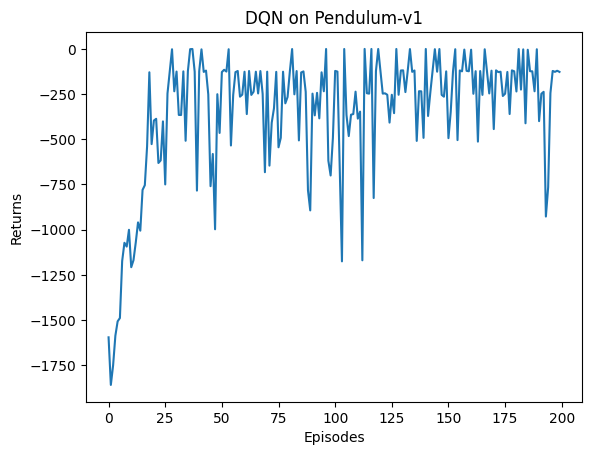

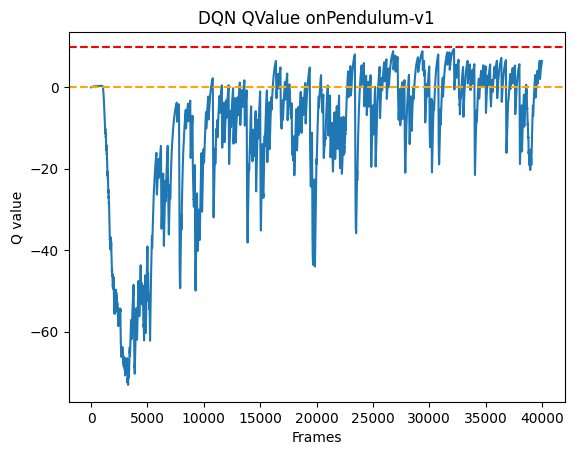

In [11]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN QValue on{}'.format(env_name))
plt.show()